In [1]:
# 每次新建项目，先到运行：

# import zipfile
# import os
# def un_zip(file_name):
#     """unzip zip file"""
#     zip_file = zipfile.ZipFile(file_name)
#     for names in zip_file.namelist():
#         zip_file.extract(names,'work/')
#     zip_file.close()

# un_zip('/home/aistudio/data/data77240/pyeeg-master.zip')

# if os.path.isdir("work/data"):
#     pass
# else:
#     os.mkdir("work/data")

"""
每次运行环境，到终端执行如下两行命令（然后重启内核）：
cd ./work/pyeeg-master
python setup.py install
"""

'\n每次运行环境，到终端执行如下两行命令（然后重启内核）：\ncd ./work/pyeeg-master\npython setup.py install\n'

In [2]:
#加载飞桨、Numpy和相关类库
import numpy as np
#import pyeeg as pe
import random
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import StratifiedShuffleSplit

import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
import paddle.fluid.optimizer as opt
from paddle.fluid.dygraph.nn import Linear

In [3]:
import numpy as np
import pylab as pl
 
def wgn(x, snr):
    snr = 10**(snr/10.0)
    xpower = np.sum(x**2)/len(x)
    npower = xpower / snr
    return np.random.randn(len(x)) * np.sqrt(npower)
 
# t = np.arange(0, 1000) * 0.1
# x = np.sin(t)
# n = wgn(x, 5)
# xn = x+n # 增加了6dBz信噪比噪声的信号

In [4]:
# 切片
def piece(data):
    allTrail = []
    channelData = data.reshape((data.shape[0], 32, 7680))
    for trail in channelData:
        oneTrail = []
        for time in range(60):
            oneTrail.append(trail[:, time * 128 : (time + 1) * 128])
        allTrail.append(np.array(oneTrail))
    return np.array(allTrail).reshape((data.shape[0] * 60, 32, 128))

In [5]:
#特征提取
def feature_extraction(trainData):
    
    band = [4,8,13,16,30,45] #5 bands    band = [4,8,12,16,25,45]  
    sample_rate = 128 #Sampling rate of 128 Hz

    newData=[]
    for i in range(trainData.shape[0]):    #样本数
        channel_features=[]
        for j in range(32):
            X = trainData[i][j]
            Y = pe.bin_power(X, band, sample_rate)
            channel_features += list(Y[0])
        newData.append(np.array(channel_features))

    return np.array(newData)

In [6]:
def Gaussian_normalization(trainData, testData):
    """高斯归一化"""

    #训练样本归一化
    feature=trainData[:,:-1]
    mean=feature.mean(axis=0)
    std=feature.std(axis=0)
    feature-=mean
    feature/=std
    trainData[:,:-1] = feature

    #测试样本归一化
    feature=testData[:,:-1]
    feature-=mean
    feature/=std
    testData[:,:-1] = feature

    return trainData, testData

In [7]:
def load_data(BATCHSIZE):
   
    # 定义数据生成器
    def data_generator():
        data_list = []
        for idx in range(50):
            data = np.load('work/trainSetFreq/{}.npy'.format(idx))

            index_list = list(range(data.shape[0]))
            random.shuffle(index_list)

            for i in index_list:
                
                data_list.append(data[i])
                if len(data_list) == BATCHSIZE:
                    yield np.array(data_list)
                    # 清空数据读取列表
                    data_list = []
        
        if len(data_list) > 0:
            yield np.array(data_list)
    return data_generator

In [8]:
class FcMLP(dygraph.Layer):
    def __init__(self):
        super(FcMLP, self).__init__()
        
        self.fc1 = Linear(input_dim = 160, output_dim = 320, act = 'relu')
        self.fc2 = Linear(input_dim = 320, output_dim = 320, act = 'relu')
        self.fc3 = Linear(input_dim = 320, output_dim = 320, act = 'relu')
        self.fc4 = Linear(input_dim = 320, output_dim = 320, act = 'relu')
        self.fc5 = Linear(input_dim = 320, output_dim = 320, act = 'relu')
        self.fc6 = Linear(input_dim = 320, output_dim = 320, act = 'relu')
        self.fc7 = Linear(input_dim = 320, output_dim = 320, act = 'relu')
        self.fc8 = Linear(input_dim = 320, output_dim = 320, act = 'relu')
        self.fc9 = Linear(input_dim = 320, output_dim = 320, act = 'relu')
        self.fc10 = Linear(input_dim = 320, output_dim = 160, act = 'relu')
        self.fc11 = Linear(input_dim = 160, output_dim = 80, act = 'relu')
        self.fc12 = Linear(input_dim = 80, output_dim = 2, act = 'softmax')
    
    def forward(self, x, label = None):
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        x = self.fc9(x)
        x = self.fc10(x)
        x = self.fc11(x)
        x = self.fc12(x)

        if label is not  None :
            acc = fluid.layers.accuracy(input = x, label = label)
            return x, acc
        else :
            return x

## 训练集、测试集的标签比例与总体样本的类标签比例相同
StratifiedShuffleSplit

In [9]:
def train(epoch, batch_size):
    
    iter_ = 0
    iters = []
    losses = []
    accs = []
    validation_losses = []
    validation_accs = []

    use_gpu = False
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    
    with dygraph.guard(place):

        model = FcMLP()
        model.train()
        
        regularization = fluid.regularizer.L2Decay(regularization_coeff=0.02)
        #regularization=regularization,
        optimizer = opt.SGDOptimizer(learning_rate=0.001, parameter_list=model.parameters())
        
        train_loader = load_data(batch_size)
        
        validationData = np.load('work/validationSetFreq.npy')
        validationFeature = validationData[:, :-1]
        validationLabel = validationData[:, -1:]

        for epoch_id in range(epoch):
            for batch_id, mini_batch in enumerate(train_loader()):
                x = mini_batch[:, :-1].astype('float32')
                y = mini_batch[:, -1:].astype('int64')
                
                x = dygraph.to_variable(x)
                y = dygraph.to_variable(y)
                
                predict, acc = model(x, y)

                loss = fluid.layers.cross_entropy(predict, label = y)
                avg_loss = fluid.layers.mean(loss)

                if batch_id % 1000 == 0:
                    iters.append(iter_)
                    iter_ += 1
                    losses.append(avg_loss.numpy())
                    accs.append(acc.numpy())
                    if iter_ % 7 == 0 :
                        print('epoch : ', epoch_id, 'batch_id : ', batch_id, 'loss = ', avg_loss.numpy(), 'acc = ', acc.numpy())

                    # 记录验证集准确率
                    x = validationFeature.astype('float32')
                    y = validationLabel.astype('int64')

                    x = dygraph.to_variable(x)
                    y = dygraph.to_variable(y)

                    predict, acc = model(x, y)
                    loss = fluid.layers.cross_entropy(input = predict, label = y)
                    validation_avg_loss = fluid.layers.mean(loss)

                    validation_losses.append(validation_avg_loss.numpy())
                    validation_accs.append(acc.numpy())

                avg_loss.backward()
                optimizer.minimize(avg_loss)
                model.clear_gradients()
        fluid.save_dygraph(model.state_dict(), 'FcMLP')


    #画出训练过程中Loss的变化曲线
    #plt.figure()
    #plt.subplot(211)
    plt.title("loss", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("loss", fontsize=14)

    plt.plot(iters, validation_losses,color='red',label='validation loss')
    plt.plot(iters, losses,color='blue',label='train loss') 

    plt.grid()
    plt.legend()
    plt.show()

    plt.title("accuracy", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("accuracy", fontsize=14)

    plt.plot(iters, validation_accs, color='red', label='validation accuracy')
    plt.plot(iters, accs, color='blue', label='train accuracy')

    plt.grid()
    plt.legend()
    plt.show()

In [10]:
def test():
    with fluid.dygraph.guard():
        model = FcMLP()
        model_dict, _ = fluid.load_dygraph('FcMLP')
        model.load_dict(model_dict)
        model.eval()
        testData = np.load('work/testSetFreq.npy')

        x = testData[:, :-1].astype('float32')
        y = testData[:, -1:].astype('int64')

        x = dygraph.to_variable(x)
        y = dygraph.to_variable(y)

        predict, acc = model(x, y)

        loss = fluid.layers.cross_entropy(input = predict, label = y)
        avg_loss = fluid.layers.mean(loss)

        print('test loss={}, test acc={}'.format(avg_loss.numpy(), acc.numpy()))
        return acc.numpy()

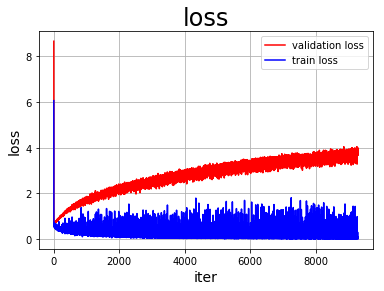

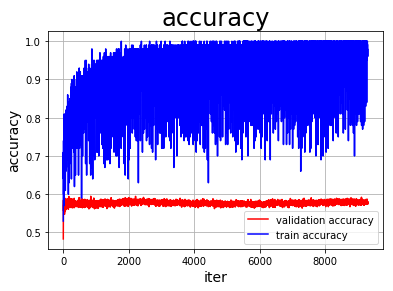

test loss=[3.95669], test acc=[0.565625]


In [11]:
train(epoch = 300, batch_size = 100)#epoch = 20
acc = test()
#print(acc)

In [12]:
# emotionDim = 0    #0 Valence 1 Arousal

# multiples = 249    #数据增强multiple倍
# snr = 5    #信噪比
# ratio = 0.2    #验证集和测试集占总体的比例
# validation_test_ratio = 0.5
# num_splits = 10    #测试10次
# randomState = 2021    #随机状态
# allAcc = []    #记录num_splits次的准确率

# dir = '/home/aistudio/data/data57707/1280x258050(32x8064+2).npy'

# AllSub = np.load(dir)
# feature = AllSub[: , :-2].reshape((1280, 32, 8064))

# feature = feature[:, :, 384:]
# feature = feature.reshape((1280, 245760))

# label = np.where(AllSub[: , -2:] >= 5 , 1 , 0)
# label = label[:, emotionDim]
# del AllSub

# sss = StratifiedShuffleSplit(n_splits=num_splits, test_size=ratio, random_state = randomState)#分成num_splits组，测试比例为ratio
# num_split = 1    #第一次split
# for train_index, test_index in sss.split(feature, label):
#     X_train, X_test = feature[train_index], feature[test_index]#训练集对应的值
#     y_train, y_test = label[train_index], label[test_index]#类别集对应的值
    
    
#     unitSignal = piece(X_train)
#     unitSignal = feature_extraction(unitSignal)
#     unitLabel = []
#     for idx in range(unitSignal.shape[0]):
#         unitLabel.append(y_train[idx // 60])
#     np.save('./work/trainSetFreq/{}.npy'.format(0), np.append(unitSignal, np.array(unitLabel).reshape((-1, 1)), axis = 1))
    
#     unitSignal = piece(X_test)
#     unitSignal = feature_extraction(unitSignal)
#     unitLabel = []
#     for idx in range(unitSignal.shape[0]):
#         unitLabel.append(y_test[idx // 60])
    
#     np.save('./work/validationSetFreq.npy', np.append(unitSignal, np.array(unitLabel).reshape((-1, 1)), axis = 1)[:int(validation_test_ratio * unitSignal.shape[0])])
#     np.save('./work/testSetFreq.npy', np.append(unitSignal, np.array(unitLabel).reshape((-1, 1)), axis = 1)[int(validation_test_ratio * unitSignal.shape[0]):])
    
#     # 添加高斯白噪声，训练数据增强multiple倍
#     for multiple in range(multiples):
#         newSignal = []
#         for signal in X_train:
#             newChannelFeature = []
#             channelFeature = signal.reshape((32, 7680))
#             for channel in channelFeature:
#                 noise = wgn(channel, snr)
#                 noiseSignal = channel + noise
#                 newChannelFeature.append(noiseSignal)
#             newChannelFeature = np.array(newChannelFeature).reshape(245760)
#             newSignal.append(newChannelFeature)
#         newSignal = np.array(newSignal)
        
        
        
#         unitSignal = piece(newSignal)
#         unitSignal = feature_extraction(unitSignal)
#         unitLabel = []
#         for idx in range(unitSignal.shape[0]):
#             unitLabel.append(y_train[idx // 60])
#         np.save('./work/trainSetFreq/{}.npy'.format(multiple + 1), np.append(unitSignal, np.array(unitLabel).reshape((-1, 1)), axis = 1))
        
#     del X_test
#     del X_train
#     del y_train
#     del y_test
#     del unitSignal
#     del unitLabel
    
    
#     #加载训练集、测试集，开始训练、测试

#     if num_split == 1:
#         print('trainShape = ', int(1280 * 0.8) * 60 * 250, 'validationShape = ', int(1280 * 0.1) * 60, 'testShape = ', int(1280 * 0.1) * 60)
    
#     # normal = True
#     # if normal:
#     #     trainSet, testSet = Gaussian_normalization(trainSet, testSet)

#     # 训练
#     print('split{} ：'.format(num_split), end = '')
#     num_split += 1
#     train(epoch = 2, batch_size = 20)
#     acc = test()
#     allAcc.append(acc)

In [13]:
# allAcc = np.array(allAcc)

# maxIndex = allAcc.argmax()
# print('meanAcc = ', allAcc.mean(),'num_split = ', maxIndex, 'maxAcc = ',allAcc.max(), 'var = ',allAcc.var())

# plt.ylim([0,1])
# plt.xlabel('num_split')
# plt.ylabel('acc')
# plt.plot(range(1,11), allAcc)

In [14]:
# normal = False meanAcc = 0.581
# normal = True meanAcc = 0.5811